# Simple feed forward NN to predict IC50 based on patient demographic and molecular drug information (INCLUDES CELL LINE FEATURE FOR TRAINING)

In [2]:
from CHEM277B_functions import *

In [3]:
valid_IC50s = pd.read_csv("data/valid_IC50s_within_range.csv")
merged_df = pd.read_csv("data/final_merged_imputed_race_CSV.csv")
lucas_df = pd.read_csv("data/Raw_Mapping_Imputed_Race.csv")
cell_lines_df = pd.read_csv("data/HarvardCellLines.csv")

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_12486/1684730604.py:2: DtypeWarning: Columns (3,4,5,6,7,9,12,15,16,17,18,22,24,26,28,29,30,67) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("final_merged_imputed_race_CSV.csv")


In [4]:
valid_IC50s.drop(columns = ['Unnamed: 0', 'N Points'], inplace = True)

In [5]:
columns = ["HMS LINCS Batch ID", "Name", "T Stage"]
cell_lines_df = cell_lines_df[columns]

# USE LUCAS' DATASET STARTING HERE

In [7]:
merged_df['T_stage_by_size'] = merged_df.apply(lambda row: row['T Stage'] if pd.notnull(row['T Stage']) else T_stage_by_size(row['Tumor Size']), axis=1)

In [8]:
columns = ['Age', 'Race', 'T_stage_by_size']
patients_df = merged_df[columns]

In [9]:
patients_df["cell_lines"] = lucas_df["Matched Cell Line ID"]

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_12486/3231217547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df["cell_lines"] = lucas_df["Matched Cell Line ID"]


In [11]:
cell_lines_df_dict = cell_lines_df.set_index("HMS LINCS Batch ID").to_dict()["Name"]

In [13]:
def mapping(row, dictionary):
    return dictionary[row]

In [14]:
patients_df["Cell Name"] = patients_df["cell_lines"].apply(mapping, dictionary = cell_lines_df_dict)

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_12486/1850949227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df["Cell Name"] = patients_df["cell_lines"].apply(mapping, dictionary = cell_lines_df_dict)


In [15]:
patients_df.dropna(inplace=True)
patients_df.isna().sum()

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_12486/2483854490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df.dropna(inplace=True)


Age                0
Race               0
T_stage_by_size    0
cell_lines         0
Cell Name          0
dtype: int64

# Add Small Molecule descriptors for each row. 

In [17]:
drugs_df = pd.read_csv("Descriptors_Small_Molecules.csv")
drugs_df = drugs_df[['Name', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
drugs_df.rename(columns={'Name': 'Small Molecule Name'}, inplace=True)

In [18]:
valid_IC50s = pd.merge(valid_IC50s, drugs_df, on='Small Molecule Name', how='left')

In [19]:
patient_drug_df = pd.merge(patients_df, valid_IC50s, on='Cell Name', how='left')

In [20]:
patient_drug_df.drop(columns = "cell_lines", inplace=True)

In [21]:
patient_drug_df.to_csv("patient_drug_information_aka_final_final_final.csv")

In [22]:
race_dict = {0:'N/A', 1:"white", 2:"black", 3:"asian", 4:"native", 5:"hispanic", 6:"multi", 7:"hawa", 8:"amer indian"}

In [23]:
patient_drug_df["Race"] = patient_drug_df["Race"].apply(mapping, dictionary = race_dict)

### Cell lines are proxy for patients, so drop the cell lines column. 

### Need to one-hot-encode categorical features

In [42]:
categorical_cols = ['Race', 'T_stage_by_size', 'Small Molecule Name', 'Cell Name']
patient_drug_df[categorical_cols] = patient_drug_df[categorical_cols].astype('category')

In [44]:
patient_drug_df_encoded = pd.get_dummies(patient_drug_df, columns=categorical_cols, drop_first=True)

In [46]:
bool_cols = patient_drug_df_encoded.select_dtypes(include='bool').columns
patient_drug_df_encoded[bool_cols] = patient_drug_df_encoded[bool_cols].astype(int)

### PRE-PROCESSING DONE. ONTO MODEL TRAINING.

In [49]:
# Separate features (X) and target (y)
X = patient_drug_df_encoded.drop(columns=['EC50 (uM)'])  # Drop EC50 and non-features
y = patient_drug_df_encoded['EC50 (uM)']  # EC50 is the target

# Standardize numerical features
scaler = StandardScaler()
X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']] = scaler.fit_transform(X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]) 

In [51]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# FEED FORWARD NEURAL NETWORK 
class DrugEncoder(nn.Module):
    def __init__(self, input_dim=5):  # 5 molecular descriptors
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

    def forward(self, x):
        return self.encoder(x.float())

# SIMGPLE FEED FORWARD NEURAL NETWORK 
class PatientEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

    def forward(self, x):
        return self.encoder(x.float())

# REGRESSION PREDICTION WITH SIMPLE FEED FORWARD NEURAL NETWORK

class DrugResponsePredictor(nn.Module):
    def __init__(self, drug_input_dim, patient_input_dim):
        super().__init__()
        self.drug_encoder = DrugEncoder(drug_input_dim)
        self.patient_encoder = PatientEncoder(patient_input_dim)
        self.fc = nn.Sequential(
            nn.Linear(32 + 32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # IC50 prediction
        )

    def forward(self, drug_feat, patient_feat):
        drug_vec = self.drug_encoder(drug_feat)
        patient_vec = self.patient_encoder(patient_feat)
        combined = torch.cat([drug_vec, patient_vec], dim=1)
        return self.fc(combined).squeeze(-1)


In [55]:
# Data
# Select drug descriptor columns
drug_feature_cols = ['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']
drug_features = X_train[drug_feature_cols].to_numpy()  # (n_samples, 5)

# Drop drug features to get patient features
patient_features = X_train.drop(columns=drug_feature_cols).to_numpy()

# Convert to tensors
drug_tensor = torch.tensor(drug_features).float()
patient_tensor = torch.tensor(patient_features).float()
ic50_tensor = torch.tensor(y_train.to_numpy()).float()

model = DrugResponsePredictor(drug_input_dim=5, patient_input_dim=patient_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


# Training loop
model.train()
start_time = time.time()

my_epochs = []
my_losses = []

for epoch in range(500):  
    optimizer.zero_grad()
    preds = model(drug_tensor, patient_tensor)
    loss = loss_fn(preds, ic50_tensor)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    print(f"Time elapsed: {elapsed:.2f} seconds")
    my_epochs.append(epoch)
    my_losses.append(loss.item())


Epoch 0 | Loss: 3.2312
Time elapsed: 0.06 seconds
Epoch 1 | Loss: 3.1874
Time elapsed: 0.10 seconds
Epoch 2 | Loss: 3.1462
Time elapsed: 0.13 seconds
Epoch 3 | Loss: 3.1065
Time elapsed: 0.16 seconds
Epoch 4 | Loss: 3.0681
Time elapsed: 0.20 seconds
Epoch 5 | Loss: 3.0308
Time elapsed: 0.23 seconds
Epoch 6 | Loss: 2.9941
Time elapsed: 0.26 seconds
Epoch 7 | Loss: 2.9579
Time elapsed: 0.30 seconds
Epoch 8 | Loss: 2.9220
Time elapsed: 0.33 seconds
Epoch 9 | Loss: 2.8867
Time elapsed: 0.36 seconds
Epoch 10 | Loss: 2.8524
Time elapsed: 0.40 seconds
Epoch 11 | Loss: 2.8190
Time elapsed: 0.43 seconds
Epoch 12 | Loss: 2.7866
Time elapsed: 0.46 seconds
Epoch 13 | Loss: 2.7546
Time elapsed: 0.50 seconds
Epoch 14 | Loss: 2.7230
Time elapsed: 0.53 seconds
Epoch 15 | Loss: 2.6914
Time elapsed: 0.56 seconds
Epoch 16 | Loss: 2.6596
Time elapsed: 0.59 seconds
Epoch 17 | Loss: 2.6275
Time elapsed: 0.63 seconds
Epoch 18 | Loss: 2.5950
Time elapsed: 0.66 seconds
Epoch 19 | Loss: 2.5623
Time elapsed: 0.6

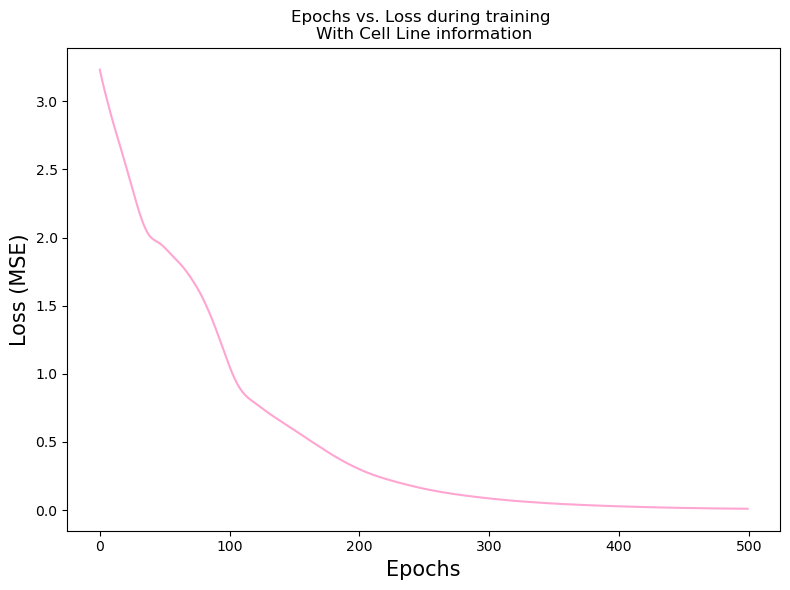

In [57]:
epochs_vs_loss_with_cells(my_epochs,my_losses)

In [59]:
model = DrugResponsePredictor(drug_input_dim=5, patient_input_dim=patient_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


# Training loop
model.train()
start_time = time.time()

my_epochs = []
my_losses = []

for epoch in range(300):  
    optimizer.zero_grad()
    preds = model(drug_tensor, patient_tensor)
    loss = loss_fn(preds, ic50_tensor)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    print(f"Time elapsed: {elapsed:.2f} seconds")
    my_epochs.append(epoch)
    my_losses.append(loss.item())

Epoch 0 | Loss: 3.0935
Time elapsed: 0.06 seconds
Epoch 1 | Loss: 3.0416
Time elapsed: 0.10 seconds
Epoch 2 | Loss: 2.9909
Time elapsed: 0.14 seconds
Epoch 3 | Loss: 2.9418
Time elapsed: 0.17 seconds
Epoch 4 | Loss: 2.8942
Time elapsed: 0.21 seconds
Epoch 5 | Loss: 2.8478
Time elapsed: 0.24 seconds
Epoch 6 | Loss: 2.8023
Time elapsed: 0.27 seconds
Epoch 7 | Loss: 2.7578
Time elapsed: 0.31 seconds
Epoch 8 | Loss: 2.7144
Time elapsed: 0.34 seconds
Epoch 9 | Loss: 2.6727
Time elapsed: 0.37 seconds
Epoch 10 | Loss: 2.6321
Time elapsed: 0.41 seconds
Epoch 11 | Loss: 2.5922
Time elapsed: 0.44 seconds
Epoch 12 | Loss: 2.5527
Time elapsed: 0.47 seconds
Epoch 13 | Loss: 2.5135
Time elapsed: 0.50 seconds
Epoch 14 | Loss: 2.4743
Time elapsed: 0.54 seconds
Epoch 15 | Loss: 2.4354
Time elapsed: 0.57 seconds
Epoch 16 | Loss: 2.3968
Time elapsed: 0.60 seconds
Epoch 17 | Loss: 2.3586
Time elapsed: 0.63 seconds
Epoch 18 | Loss: 2.3212
Time elapsed: 0.66 seconds
Epoch 19 | Loss: 2.2852
Time elapsed: 0.7

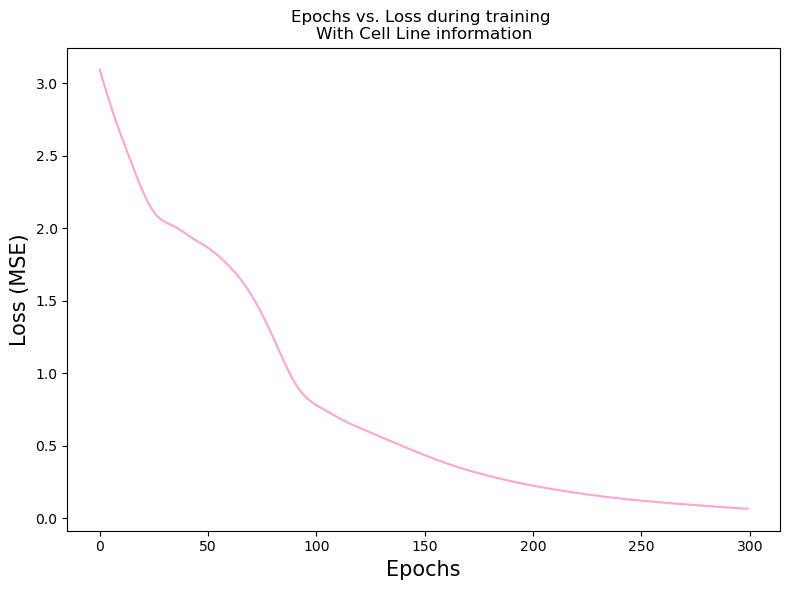

In [61]:
epochs_vs_loss_with_cells(my_epochs,my_losses)

In [63]:
drug_features_test = X_test[['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
patient_features_test = X_test.drop(columns=drug_features_test.columns)

metrics = evaluate_model(model, drug_features_test, patient_features_test, y_test)

print(f"MSE: {metrics[0]:.4f}")
print(f"MAE: {metrics[1]:.4f}")
print(f"R²: {metrics[2]:.4f}")


MSE: 0.0650
MAE: 0.1026
R²: 0.9706


/Users/joyceyu/Documents/CHEM277B - ML Algorithms/Final project/Data_277_-Cancer/CHEM277B_functions.py:108: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal', color = "Black")


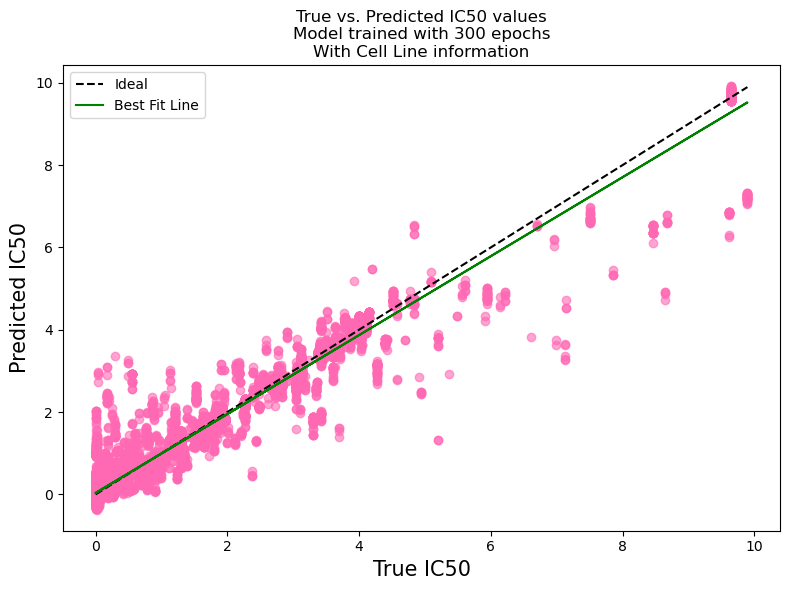

In [65]:
with torch.no_grad():
    preds = model(torch.tensor(drug_features_test.values).float(),
                  torch.tensor(patient_features_test.values).float()).cpu().numpy()
plot_pred_vs_true_with_cells(y_test.to_numpy(), preds)

In [69]:
k_fold_cv = compute_CV_error(X_train, y_train)

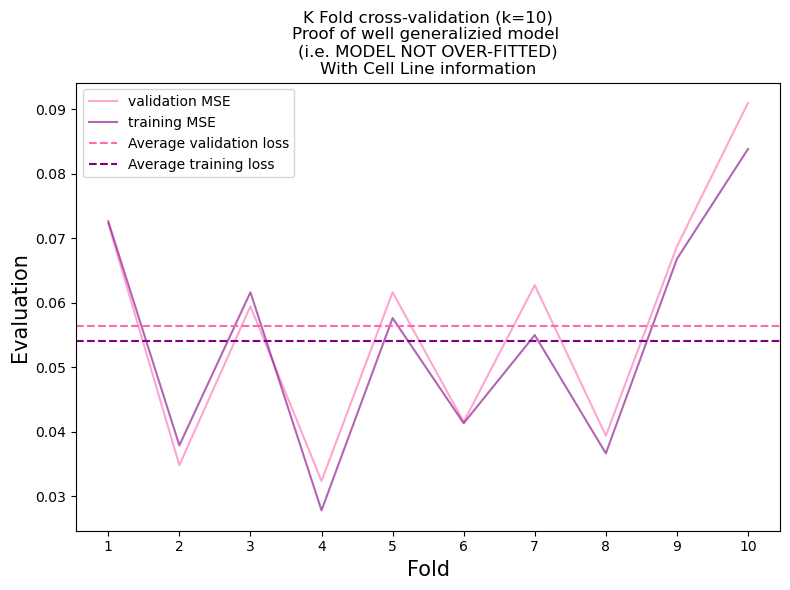

In [71]:
Kfold_CV_plot_with_cells(k_fold_cv)